# 식물 잎의 사진으로 질병 분류하기(전이학습을 배워보자)

## 데이터 준비 및 정리

In [1]:
# 데이터 압축 파일 풀기
!unzip -qq '/content/drive/MyDrive/제로베이스스쿨 공부/Deep Learning/data/dataset.zip' -d './dataset'

In [2]:
import os

original_dataset_dir = './dataset'
classes_list = os.listdir(original_dataset_dir) # 데이터셋이 있는 폴더

base_dir = './splitted' # 나중에 Train, Test, Val 데이터를 분리시킬 폴더
os.mkdir(base_dir)

In [3]:
# 데이터 정리를 위한 목록 및 폴더 생성
import shutil

## base_dir 하위에 각각의 폴더 생성
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'val')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

for cls in classes_list: # 생성된 폴더에도 기존 데이터에 있던 하위 폴더들 생성
  os.mkdir(os.path.join(train_dir, cls))
  os.mkdir(os.path.join(validation_dir, cls))
  os.mkdir(os.path.join(test_dir, cls))

In [4]:
# 데이터 확인
import math

for cls in classes_list:
    path = os.path.join(original_dataset_dir, cls) # 기존 데이터의 폴더명
    fnames = os.listdir(path) # path 폴더에 있는 파일명 저장

    # 불러온 파일들을 6:2:2로 train / val / test로 분리
    train_size = math.floor(len(fnames) * 0.6)
    validation_size = math.floor(len(fnames) * 0.2)
    test_size = math.floor(len(fnames) * 0.2)

    # 각 인덱스에 해당하는 파일들을 각 폴더에 저장
    train_fnames = fnames[:train_size]
    print("Train size((",cls,") :", len(train_fnames))
    for fname in train_fnames:
        src = os.path.join(path, fname) # 기존 파일 경로
        dst = os.path.join(os.path.join(train_dir, cls), fname) # 카피할 파일 경로
        shutil.copyfile(src, dst) # 새로 생성된 train dir에 파일 저장

    validation_fnames = fnames[train_size:(validation_size + train_size)]
    print("Validation size((",cls,") :", len(validation_fnames))
    for fname in validation_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(validation_dir, cls), fname)
        shutil.copyfile(src, dst) # 새로 생성된 validation dir에 파일 저장

    test_fnames = fnames[(train_size + validation_size):(validation_size + train_size + test_size)]
    print("Test size((",cls,") :", len(test_fnames))
    for fname in test_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(test_dir, cls), fname)
        shutil.copyfile(src, dst) # 새로 생성된 test dir에 파일 저장

Train size(( Tomato___Tomato_Yellow_Leaf_Curl_Virus ) : 3214
Validation size(( Tomato___Tomato_Yellow_Leaf_Curl_Virus ) : 1071
Test size(( Tomato___Tomato_Yellow_Leaf_Curl_Virus ) : 1071
Train size(( Tomato___Bacterial_spot ) : 1276
Validation size(( Tomato___Bacterial_spot ) : 425
Test size(( Tomato___Bacterial_spot ) : 425
Train size(( Apple___Black_rot ) : 372
Validation size(( Apple___Black_rot ) : 124
Test size(( Apple___Black_rot ) : 124
Train size(( Corn___Cercospora_leaf_spot Gray_leaf_spot ) : 307
Validation size(( Corn___Cercospora_leaf_spot Gray_leaf_spot ) : 102
Test size(( Corn___Cercospora_leaf_spot Gray_leaf_spot ) : 102
Train size(( Apple___healthy ) : 987
Validation size(( Apple___healthy ) : 329
Test size(( Apple___healthy ) : 329
Train size(( Peach___Bacterial_spot ) : 1378
Validation size(( Peach___Bacterial_spot ) : 459
Test size(( Peach___Bacterial_spot ) : 459
Train size(( Potato___Late_blight ) : 600
Validation size(( Potato___Late_blight ) : 200
Test size(( Pot

## 모델링

In [6]:
import torch
import os

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
BATCH_SIZE = 256
EPOCH = 30

DEVICE

device(type='cuda')

In [7]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# 사진의 파일이 제각각이므로 resize를 통해 64 * 64로 맞춰주고 tensor로 변환
transform_base = transforms.Compose([transforms.Resize((64, 64 )), transforms.ToTensor()])

# ImageFolder: 폴더 구조로 이루어진 데이터셋을 처리하기 위한 클래스
train_dataset = ImageFolder(root='./splitted/train', transform=transform_base)
val_dataset = ImageFolder(root='./splitted/val', transform=transform_base)

In [8]:
# 배치로 쪼개기
from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=4)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
first_batch = train_loader.__iter__().__next__() # 첫번째 배치만 가져옴

# 결과 확인
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)),
                                     len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])),
                                     first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])),
                                     first_batch[1].shape))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


name            | type                      | size
Num of Batch    |                           | 94
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([256, 3, 64, 64])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([256])


### 모델 구성

위 배치 사이즈  torch.Size([256, 3, 64, 64]) 를 참고하여 모델을 구성해주어야한다.

In [11]:
# 모델링
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## nn.Conv2D(입력받는 채널 수, 출력할 채널 수, 커널 사이즈, padding 옵션)
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.fc1 = nn.Linear(4096, 512) # 8 * 8 * 64 = 4096
        self.fc2 = nn.Linear(512, 33)

    def forward(self, x):

        x = self.conv1(x) # (64, 64)
        x = F.relu(x)
        x = self.pool(x) # (32, 32)
        x = F.dropout(x, p=0.25, training=self.training) # train 모드에서만 dropout 사용

        x = self.conv2(x) # (32 , 32)
        x = F.relu(x)
        x = self.pool(x) # (16, 16)
        x = F.dropout(x, p=0.25, training=self.training)

        x = self.conv3(x) # (16, 16)
        x = F.relu(x)
        x = self.pool(x) # (8, 8)
        x = F.dropout(x, p=0.25, training=self.training)

        x = x.view(-1, 4096) # flatten()
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training = self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

# 모델 선언
model_base = Net().to(DEVICE)
optimizer = optim.Adam(model_base.parameters(), lr=0.001)

In [12]:
# 학습
def train(model, train_loader, optimizer):
    model.train() # 모드 선언
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)

        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)

        loss.backward()
        optimizer.step()

# 평가
def evaluate(model, test_loader):
    model.eval() # 모드 선언
    test_loss = 0
    correct = 0

    # with 자원을 열면 닫지 않아도 with 구문이 끝나면 알아서 닫아줌(error대응 잘함)
    with torch.no_grad(): # gradient가 없는동안 아래 동작을 실시하라
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            test_loss += F.cross_entropy(output, target, reduction='sum').item()

            pred = output.max(1, keepdim=True)[1] # 최대값 위치의 클래스가 최종 클래스
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)   # 맞는 개수
    return test_loss, test_accuracy

In [13]:
import time
import copy

def train_baseline(model, train_loader, val_loader, optimizer, num_epochs = 30):
    best_acc = 0.0 # 가장 좋은 acc를 저장할 변수
    best_model_wts = copy.deepcopy(model.state_dict()) # 가장 좋은 acc 모델의 weight 저장

    for epoch in range(1, num_epochs + 1):
        since = time.time()
        train(model, train_loader, optimizer) # 학습
        train_loss, train_acc = evaluate(model, train_loader) # train에 대한 평가
        val_loss, val_acc = evaluate(model, val_loader) # val에 대한 평가

        if val_acc > best_acc:  # 30번의 epoch 중 가장 val_accuracy가 좋은 weight를 저장
            best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('----------------- epoch {} -----------------'.format(epoch))
        print('train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))
        print('val Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))
        print('Complieted in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    model.load_state_dict(best_model_wts)
    return model

base = train_baseline(model_base, train_loader, val_loader, optimizer, EPOCH)
torch.save(base, 'baseline.pt') # 파이토치 파일로 가장 좋은 acc 모델 저장

----------------- epoch 1 -----------------
train Loss: 1.8209, Accuracy: 49.84%
val Loss: 1.8272, Accuracy: 49.78%
Complieted in 1m 11s
----------------- epoch 2 -----------------
train Loss: 1.0724, Accuracy: 67.66%
val Loss: 1.1012, Accuracy: 67.22%
Complieted in 1m 12s
----------------- epoch 3 -----------------
train Loss: 0.8449, Accuracy: 74.79%
val Loss: 0.8814, Accuracy: 73.98%
Complieted in 1m 7s
----------------- epoch 4 -----------------
train Loss: 0.6580, Accuracy: 80.01%
val Loss: 0.7150, Accuracy: 78.08%
Complieted in 1m 7s
----------------- epoch 5 -----------------
train Loss: 0.5256, Accuracy: 83.70%
val Loss: 0.5956, Accuracy: 81.39%
Complieted in 1m 2s
----------------- epoch 6 -----------------
train Loss: 0.4440, Accuracy: 86.57%
val Loss: 0.5202, Accuracy: 84.28%
Complieted in 1m 4s
----------------- epoch 7 -----------------
train Loss: 0.3863, Accuracy: 88.51%
val Loss: 0.4691, Accuracy: 85.51%
Complieted in 1m 2s
----------------- epoch 8 -----------------
tr

In [14]:
base

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=33, bias=True)
)

## 전이학습

### 이미지 증강

In [20]:
data_transforms = {     # 과적합 방지용 -> 돌리고, 상하좌우 반전, 이미지 자르기, 색상
    'train' : transforms.Compose([transforms.Resize([64, 64]),
        transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),
        transforms.RandomCrop(52), transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ]),
                        # RGB 색상값의 평균과 표준편차를 설정하여 normalize
                        # 해당 작업을 해주면 컬러 이미지에 대한 학습 성능이 좋아짐

    'val' : transforms.Compose([transforms.Resize([64, 64]),
        transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),
        transforms.RandomCrop(52), transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ]),
}

In [21]:
data_dir = './splitted'

# 데이터 변형
image_datasets = {x: ImageFolder(root=os.path.join(data_dir, x),
                                 transform=data_transforms[x]) for x in ['train', 'val']}
# 배치 나누기
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size = BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes # 클래스명 담긴 변수

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [23]:
len(class_names)

33

### 학습된 모델 불러오기

```from torchvision import models``` 을 이용하면 여러 학습된 모델을 불러올 수 있음.

In [24]:
from torchvision import models

# resnet50
resnet = models.resnet50(pretrained=True)
                        # True - 학습이 완료된 weight 가져옴 / False - 구조만 가져옴
'''
대부분 사전 학습된 모델과 우리의 데이터의 출력될 클래스의 숫자가 다를 것이다.
이를 생각하고 항상 마지막 레이어의 숫자를 변형해주어야한다!!!
'''
num_ftrs = resnet.fc.in_features # in_features - 마지막 레이어 채널 숫자에 해당하는 것
resnet.fc = nn.Linear(num_ftrs, len(class_names)) # len(class_names) : 33개로 수정
resnet = resnet.to(DEVICE)

criterion = nn.CrossEntropyLoss()
'''
filter(lambda p: p.requires_grad, resnet.parameters())
사전 학습된 모델의 weight까지 가져오는 것이지만, 마지막 레이어가 바뀌었기 때문에
해당 weight는 다시 학습시킬 필요가 있다.
'''
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001)

from torch.optim import lr_scheduler    # epoch에 따라 running rate를 바꾸는 작업을 해줌
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
                  # 7 epoch마다 running rate를 0.1씩 감소 시킴


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 127MB/s]


In [31]:
resnet.children # 맨 첫 들여쓰기의 (conv1), (bn1) 등 -> layer

<bound method Module.children of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256

### 모델 수정 후 학습시키기

In [32]:
ct = 0
for child in resnet.children(): # resnet 모델의 하위 레이어를 for문으로 추출
    ct += 1
    if ct < 6:  # 입력에 가까운 0-5번 레이어
        # 학습하지 않도록 고정
        for param in child.parameters():
            param.requires_grad = False
    # 따로 설정하지 않은 6번 ~ 레이어는 학습 시킴

In [36]:
# 학습을 하면서 가장 acc가 좋은 모델 저장
def train_resnet(model, criterion, optimizer, scheduler, num_epochs=25):
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0 # 가장 좋은 acc가 될 변수

  for epoch in range(num_epochs):
      print('----------------- epoch {} -----------------'.format(epoch+1))
      since = time.time()
      for phase in ['train', 'val']:
          # 모드 설정
          if phase == 'train':
              model.train()
          else:
              model.eval()

          # 각 epoch를 시작할 때 마다 loss, corrects 초기
          running_loss = 0.0
          runnung_corrects = 0

          # 학습
          for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(DEVICE)
              labels = labels.to(DEVICE)

              optimizer.zero_grad()

              # Train 데이터라면 gradients 업데이트를 허가
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)

                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              # loss 와 맞는 개수 계산
              # inputs.size(0) : 배치 사이즈
              running_loss += loss.item() * inputs.size(0)
              runnung_corrects += torch.sum(preds == labels.data)
          if phase == 'train': # learning rate 업데이트
              scheduler.step()

          epoch_loss = running_loss/dataset_sizes[phase]
          epoch_acc = runnung_corrects.double()/dataset_sizes[phase]

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

          # acc가 이전보다 좋아졌다면 업데이트
          if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

      time_elapsed = time.time() - since
      print('Complieted in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:.4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)

  return model

In [38]:
# 실행
model_resnet50 = train_resnet(resnet, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCH)
torch.save(model_resnet50, 'resnet50.pt') # 가장 좋았던 모델 저장

----------------- epoch 1 -----------------
train Loss: 0.0111 Acc: 0.9967
val Loss: 0.0325 Acc: 0.9889
Complieted in 1m 2s
----------------- epoch 2 -----------------
train Loss: 0.0105 Acc: 0.9966
val Loss: 0.0362 Acc: 0.9877
Complieted in 1m 6s
----------------- epoch 3 -----------------
train Loss: 0.0127 Acc: 0.9961
val Loss: 0.0373 Acc: 0.9877
Complieted in 0m 49s
----------------- epoch 4 -----------------
train Loss: 0.0127 Acc: 0.9954
val Loss: 0.0351 Acc: 0.9885
Complieted in 0m 48s
----------------- epoch 5 -----------------
train Loss: 0.0120 Acc: 0.9963
val Loss: 0.0344 Acc: 0.9892
Complieted in 0m 51s
----------------- epoch 6 -----------------
train Loss: 0.0109 Acc: 0.9963
val Loss: 0.0380 Acc: 0.9879
Complieted in 1m 1s
----------------- epoch 7 -----------------
train Loss: 0.0123 Acc: 0.9956
val Loss: 0.0361 Acc: 0.9879
Complieted in 1m 1s
----------------- epoch 8 -----------------
train Loss: 0.0120 Acc: 0.9962
val Loss: 0.0369 Acc: 0.9879
Complieted in 1m 5s
-----

### 평가하기

In [39]:
# 전처리
# 과적합 방지용 transform 그대로 적용
transform_resnet = transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.RandomCrop(52),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])

test_resNet = ImageFolder(root='./splitted/test', transform=transform_resnet)
test_loader_resNet = torch.utils.data.DataLoader(test_resNet,
                                              batch_size = BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=4)

# 저장된 모델 불러오기
resnet50 = torch.load('resnet50.pt')
resnet50.eval() # 평가 모드 선언
test_loss, test_accuracy = evaluate(resnet50, test_loader_resNet)

print('ResNet test acc:  ', test_accuracy)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


ResNet test acc:   98.97358868444111


## 전이학습과 미세조정

### 전이학습

In [41]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

keras = tf.keras

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

#### 데이터 준비

In [43]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    # 데이터를 인덱스로 분리하여 각각 train, val, test 데이터로 이용
    split = ['train[:80%]' , 'train[80%:90%]', 'train[90%:]'],
    with_info = True,
    as_supervised = True # 데이터가 라벨과 함께 튜플 형태로 저장
)

1


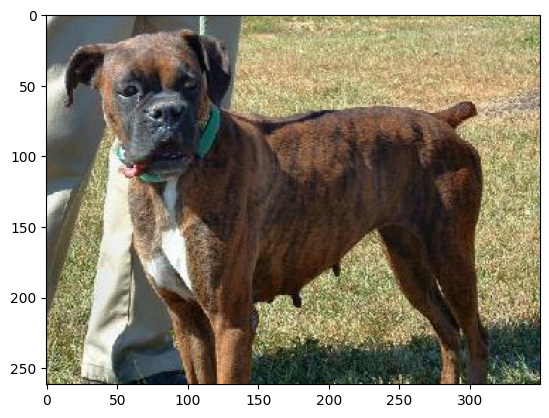

In [44]:
# 데이터 확인
for image, label in raw_train.take(1): # 하나만 가져와라
  plt.imshow(image)
  print(label.numpy())

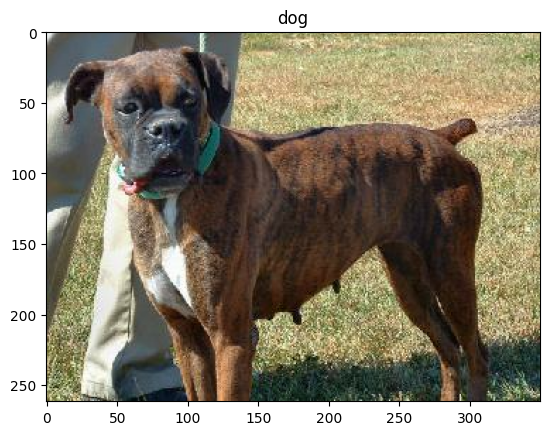

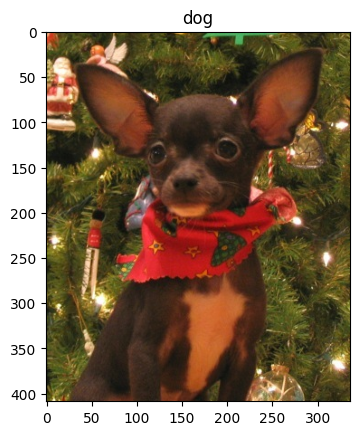

In [45]:
# 2개
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

#### 전처리

In [46]:
IMG_SIZE = 160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1 # scale
        # -1과 1 사이의 값을 가지도록 0과 255의 중간값으로 나눠주고 1 빼줌
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [47]:
# map 함수를 이용해 빠르게 적용
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [48]:
# 배치 만들고 shuffle
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [49]:
# 확인
for image_batch, label_batch in train_batches.take(1):
  pass
image_batch.shape # 적용한 이미지 사이즈와 배치 사이즈가 적용됨

TensorShape([32, 160, 160, 3])

#### MobileNet V2 모델

In [50]:
# 사전 훈련된 MobileNetV2
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet')

'''
include_top = False
# 맨 위층(맨 마지막 레이어)에는 원핫인코딩이 되어있다면
# 사전 훈련된 데이터의 원핫 인코딩이 되어있는 상태일 것이다.
# 이를 우리 데이터로 바꿔주어야하므로 맨 위층을 빼고 가져오도록 했다.

weights = 'imagenet'
# 어떤 데이터로 학습된 모델을 불러올 것인가를 설정
'''

9406464/9406464 [==============================] - 1s 0us/step


"\ninclude_top = False\n# 맨 위층(맨 마지막 레이어)에는 원핫인코딩이 되어있다면\n# 사전 훈련된 데이터의 원핫 인코딩이 되어있는 상태일 것이다.\n# 이를 우리 데이터로 바꿔주어야하므로 맨 위층을 빼고 가져오도록 했다.\n\nweights = 'imagenet'\n# 어떤 데이터로 학습된 모델을 불러올 것인가를 설정\n"

In [51]:
# (160 , 160, 3 )-> (5, 5, 1280)
feature_batch = base_model(image_batch)
feature_batch.shape # 1280 : 채널 수

TensorShape([32, 5, 5, 1280])

In [52]:
# 가중치를 그대로 사용하기 위함
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [53]:
# GlobalAveragePooling2D층
# 채널 마다의 평균값을 이용
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
feature_batch_average.shape
# GlobalAveragePooling2D층을 사용하여 특징을 이미지 한 개당 1280개의 요소 벡터로 변환

TensorShape([32, 1280])

In [54]:
# Dense 층
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
prediction_batch.shape

TensorShape([32, 1])

In [55]:
prediction_batch # 양수 -> 클래스 1 / 음수 -> 클래스 0

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[ 0.28021732],
       [ 1.2526406 ],
       [ 1.1193571 ],
       [ 0.1722736 ],
       [ 0.8320924 ],
       [ 0.83875144],
       [-0.13851753],
       [-1.481933  ],
       [-0.70650816],
       [ 0.2527576 ],
       [-0.31884056],
       [-0.23741   ],
       [-0.30935627],
       [-0.34834692],
       [ 0.46337077],
       [ 1.0355544 ],
       [ 1.109824  ],
       [-0.40722555],
       [ 0.29016376],
       [-0.2956527 ],
       [ 0.5837866 ],
       [ 0.2509107 ],
       [-1.1473589 ],
       [ 0.72990537],
       [-0.63219935],
       [-0.12092672],
       [-0.24897544],
       [ 0.48092452],
       [ 1.1549817 ],
       [-0.5628741 ],
       [ 0.68906057],
       [ 0.19550309]], dtype=float32)>

In [57]:
# 전체 모델 구성
model = tf.keras.Sequential([
    base_model, # 기존 mobilenet
    # 우리가 추가한 레이
    global_average_layer,
    prediction_layer
])

# 컴파일
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [58]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [59]:
# 학습하지 않은 현재의 성능
initial_epochs = 10
validation_steps = 20

loss0, acc0 = model.evaluate(validation_batches, steps = validation_steps)
loss0, acc0

20/20 [==============================] - 5s 39ms/step - loss: 0.8049 - accuracy: 0.4656


(0.8048564791679382, 0.46562498807907104)

In [60]:
# 학습
history = model.fit(train_batches,
                    epochs = initial_epochs,
                    validation_data = validation_batches)
# 전체 연산을 다 해야하므로 시간이 오래 걸리지만
# mobilenet을 다시 학습하는 것보단 훨씬 빠름

Epoch 1/10
582/582 [==============================] - 50s 73ms/step - loss: 0.0714 - accuracy: 0.9725 - val_loss: 0.0473 - val_accuracy: 0.9824
Epoch 2/10
582/582 [==============================] - 46s 77ms/step - loss: 0.0430 - accuracy: 0.9842 - val_loss: 0.0464 - val_accuracy: 0.9850
Epoch 3/10
582/582 [==============================] - 45s 75ms/step - loss: 0.0386 - accuracy: 0.9861 - val_loss: 0.0471 - val_accuracy: 0.9832
Epoch 4/10
582/582 [==============================] - 37s 62ms/step - loss: 0.0360 - accuracy: 0.9870 - val_loss: 0.0474 - val_accuracy: 0.9858
Epoch 5/10
582/582 [==============================] - 49s 82ms/step - loss: 0.0335 - accuracy: 0.9881 - val_loss: 0.0439 - val_accuracy: 0.9850
Epoch 6/10
582/582 [==============================] - 51s 84ms/step - loss: 0.0314 - accuracy: 0.9892 - val_loss: 0.0437 - val_accuracy: 0.9858
Epoch 7/10
582/582 [==============================] - 58s 94ms/step - loss: 0.0303 - accuracy: 0.9895 - val_loss: 0.0456 - val_accuracy:

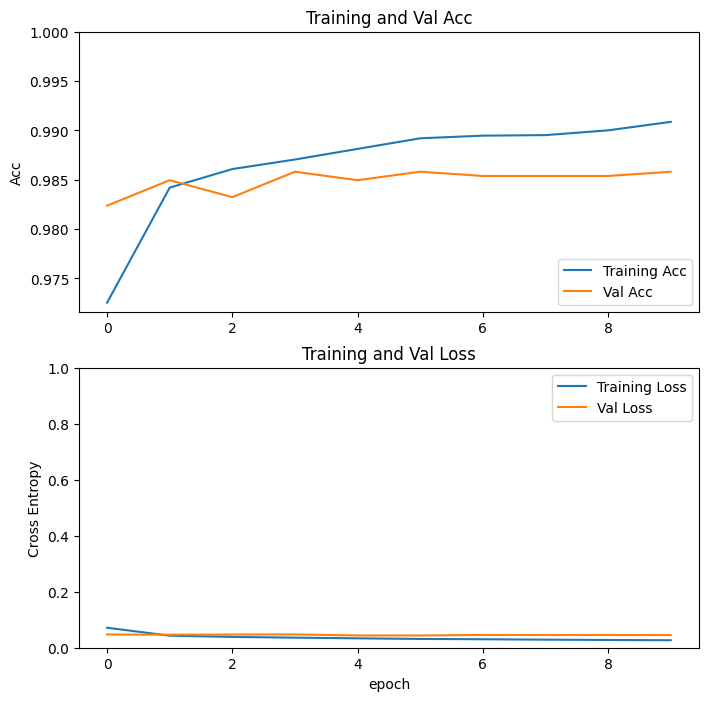

In [61]:
# 평가
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Acc')
plt.plot(val_acc, label = 'Val Acc')
plt.legend(loc = 'lower right')
plt.ylabel('Acc')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Val Acc')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Val Loss')
plt.legend(loc = 'upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Val Loss')
plt.xlabel('epoch')
plt.show()


### 미세조정

In [62]:
# 모두 trainable하게 변경
base_model.trainable = True
print('Number of layers in the base model : ', len(base_model.layers))

Number of layers in the base model :  154


In [63]:
# 100번째 층부터 튜닝 가능하게 설정
fine_tune_at = 100

# fine_tune_at 층 이전의 모든 층 고정
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [64]:
# 학습 비율 낮춤
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1862721 (7.11 MB)
Non-trainable params: 396544 (1.51 MB)
_________________________________________________________________


In [65]:
history.epoch[-1]

9

In [67]:
# 20번의 epoch
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs # 20

history_fine = model.fit(train_batches,
                         epochs = total_epochs,
                         # 이전 모델의 epoch부터 학습을 시작하게 해서
                         # 10 epoch부터 이어서 학습하게 함
                         initial_epoch = history.epoch[-1],
                         validation_data = validation_batches)

Epoch 10/20
582/582 [==============================] - 42s 71ms/step - loss: 0.1430 - accuracy: 0.9472 - val_loss: 0.5892 - val_accuracy: 0.9020
Epoch 11/20
582/582 [==============================] - 40s 66ms/step - loss: 0.0722 - accuracy: 0.9740 - val_loss: 0.8263 - val_accuracy: 0.8869
Epoch 12/20
582/582 [==============================] - 54s 91ms/step - loss: 0.0433 - accuracy: 0.9838 - val_loss: 1.0118 - val_accuracy: 0.9192
Epoch 13/20
582/582 [==============================] - 64s 105ms/step - loss: 0.0287 - accuracy: 0.9899 - val_loss: 1.1409 - val_accuracy: 0.8942
Epoch 14/20
582/582 [==============================] - 61s 101ms/step - loss: 0.0190 - accuracy: 0.9932 - val_loss: 0.3920 - val_accuracy: 0.9652
Epoch 15/20
582/582 [==============================] - 64s 108ms/step - loss: 0.0125 - accuracy: 0.9957 - val_loss: 1.0984 - val_accuracy: 0.9119
Epoch 16/20
582/582 [==============================] - 59s 97ms/step - loss: 0.0095 - accuracy: 0.9968 - val_loss: 0.2649 - val

In [68]:
# 최초 history에 방금 학습 결과 추가
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

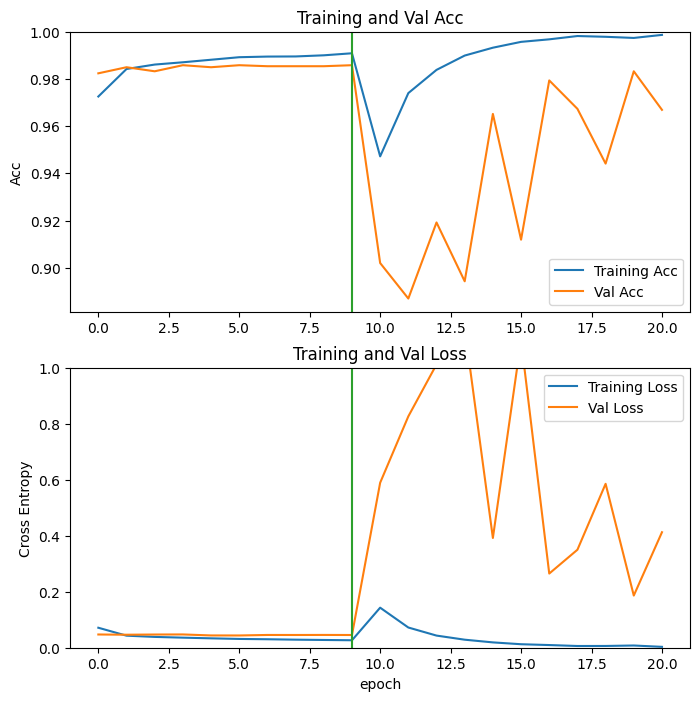

In [70]:
plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Acc')
plt.plot(val_acc, label = 'Val Acc')
plt.legend(loc = 'lower right')
plt.ylabel('Acc')
plt.ylim([min(plt.ylim()), 1])
plt.plot([initial_epochs -1, initial_epochs -1],
          plt.ylim(), label = 'Start Fine Tuning')
plt.title('Training and Val Acc')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Val Loss')
plt.legend(loc = 'upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.plot([initial_epochs -1, initial_epochs -1],
          plt.ylim(), label = 'Start Fine Tuning')
plt.title('Training and Val Loss')
plt.xlabel('epoch')
plt.show()


### 텐서플로 허브

In [71]:
#pip install -U tf-hub-nightly
import tensorflow_hub as hub

In [72]:
# mobilenet 가져오기
classifier_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2'

In [74]:
# 사전 훈련된 MobileNetV2
IMG_SHAPE = (224, 224)

classifier = tf.keras.Sequential(
    hub.KerasLayer(classifier_url, input_shape = IMG_SHAPE + (3,))
)
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
Total params: 3540265 (13.51 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 3540265 (13.51 MB)
_________________________________________________________________


61306/61306 [==============================] - 0s 1us/step


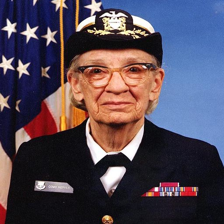

In [75]:
# 이미지 하나 확인
import PIL.Image as Image

url = "https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg"
grace_hopper = tf.keras.utils.get_file('image.jpg', url)
grace_hopper = Image.open(grace_hopper).resize(IMG_SHAPE)
grace_hopper

In [76]:
# 정규화 및 예측
grace_hopper = np.array(grace_hopper) / 255.0
print(grace_hopper.shape)

result = classifier.predict(grace_hopper[np.newaxis, ])
print(result.shape)

(224, 224, 3)
1/1 [==============================] - 1s 917ms/step
(1, 1001)


In [77]:
# argmax로 인덱스 찾기
predicted_class = np.argmax(result[0], axis = -1)
predicted_class

653

In [80]:
# label을 받아서 해당 클래스의 라벨 값 추출
url = "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', url)
imagenet_labels = np.array(open(labels_path).read().splitlines())

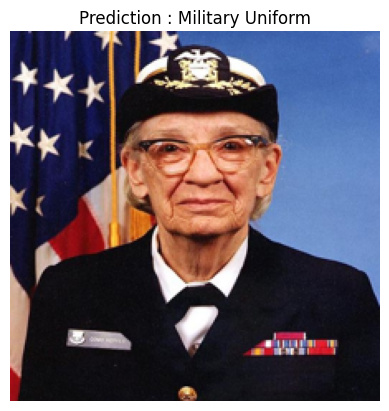

In [81]:
# 확인
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction : " + predicted_class_name.title())

### 꽃 사진

In [83]:
url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_root = tf.keras.utils.get_file('flower_photos',
                                    url,
                                    untar = True) #압축 풀기

228813984/228813984 [==============================] - 8s 0us/step


In [84]:
# rescale 및 라벨 인식
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size = IMG_SHAPE)

Found 3670 images belonging to 5 classes.


In [85]:
# 배치 생성
for image_batch, label_batch in image_data:
  print("Image batch shape : ", image_batch.shape)
  print("Label batch shape : ", label_batch.shape)
  break

Image batch shape :  (32, 224, 224, 3)
Label batch shape :  (32, 5)


In [86]:
# 배치 하나에 대한 예측 결과
result_batch = classifier.predict(image_batch)
result_batch.shape

1/1 [==============================] - 1s 694ms/step


(32, 1001)

In [87]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis = -1)]
predicted_class_names

array(['daisy', 'hip', 'velvet', 'daisy', 'tray', 'daisy', 'picket fence',
       'daisy', 'mantis', 'daisy', 'clog', 'sunglasses', 'sarong',
       'daisy', 'buckeye', 'cardoon', 'pot', 'daisy', 'birdhouse',
       'quill', 'daisy', 'picket fence', 'quill', 'bikini', 'cardoon',
       'bee', 'pot', 'cardoon', 'porcupine', 'streetcar', 'chime',
       'picket fence'], dtype='<U30')

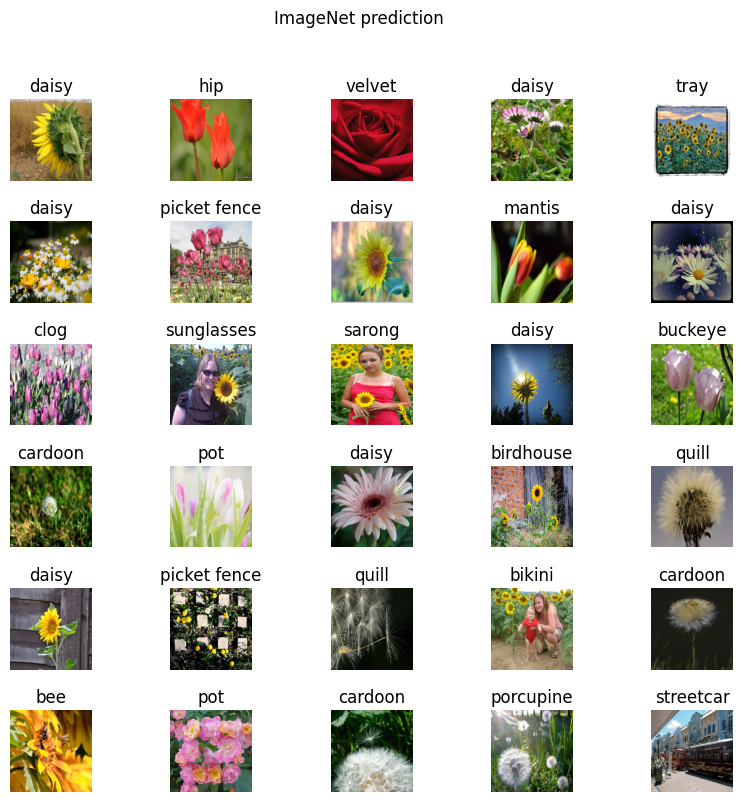

In [88]:
# 확인
plt.figure(figsize = (10, 9))
plt.subplots_adjust(hspace = 0.5)
for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle('ImageNet prediction')

In [89]:
# 특징 추출기 가져오기
feature_extractor_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2'

feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape = (224, 224, 3))

feature_batch = feature_extractor_layer(image_batch)
feature_batch.shape

TensorShape([32, 1280])

In [93]:
# dense 레이어 추가
from tensorflow.keras import layers

feature_extractor_layer.trainable = False

model = tf.keras.Sequential([
    feature_extractor_layer,
              # 마지막 라벨은 나의 데이터 클래스에 맞춰서
    layers.Dense(image_data.num_classes, activation = 'softmax')
])

In [94]:
# 마지막 레이어
predictions = model(image_batch)
predictions.shape

TensorShape([32, 5])

In [96]:
# 컴파일
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['acc']
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [97]:
# callback 정의
class CollectBatchStats(tf.keras.callbacks.Callback):
  # loss와 acc를 배치별로 출력해줌
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs = None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [99]:
# 학습
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs = 2,
                              steps_per_epoch = steps_per_epoch,
                              callbacks = [batch_stats_callback])

Epoch 1/2


<ipython-input-99-2c483c310a92>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(image_data, epochs = 2,


115/115 [==============================] - 22s 157ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 2/2
115/115 [==============================] - 21s 179ms/step - loss: 0.0000e+00 - acc: 0.0000e+00


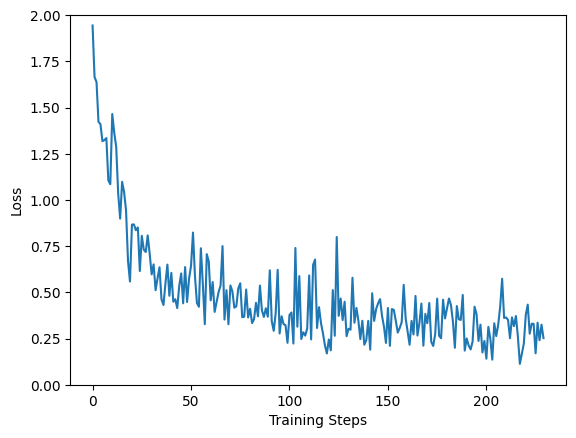

In [100]:
# loss에 대한 성능 그래프
plt.figure()
plt.ylabel('Loss')
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

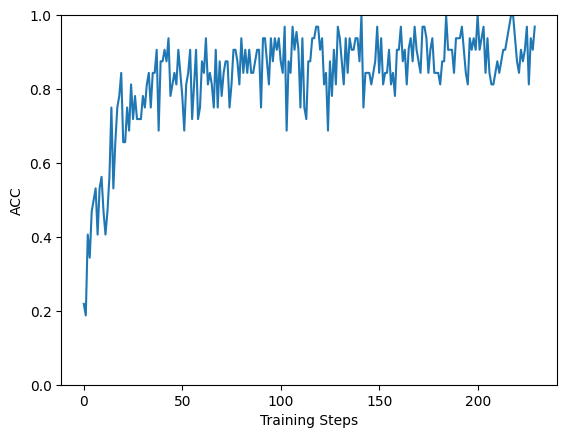

In [101]:
# acc에 대한 성능 그래프
plt.figure()
plt.ylabel('ACC')
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

loss는 점점 떨어지고 acc는 점점 증가하는 좋은 현상

In [102]:
# class name 할당
class_names  = sorted(image_data.class_indices.items(), key = lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [103]:
# 다시 예측
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis = -1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis = -1)

1/1 [==============================] - 1s 796ms/step


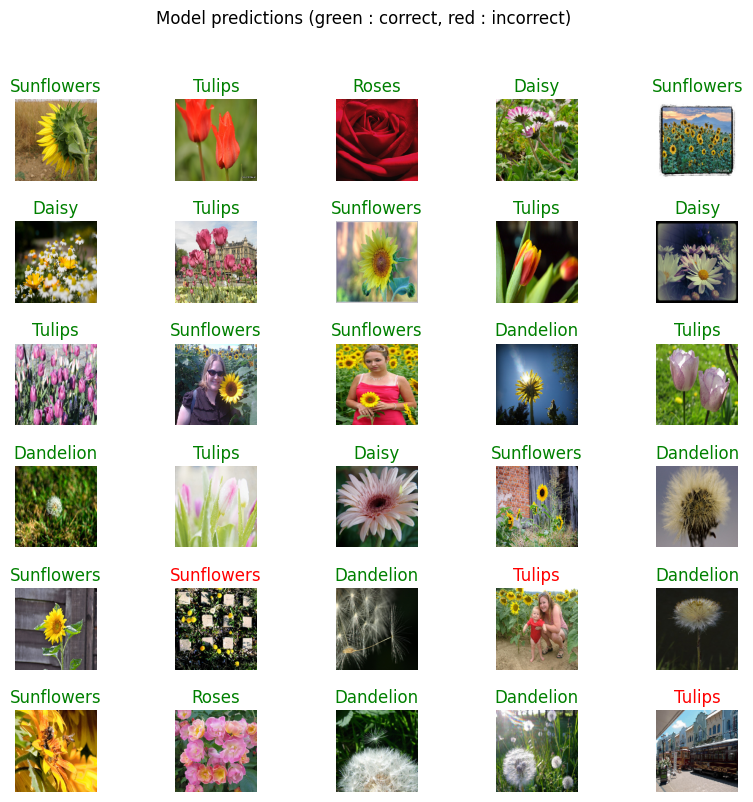

In [104]:
plt.figure(figsize = (10, 9))
plt.subplots_adjust(hspace = 0.5)
for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.imshow(image_batch[n])
  # 정답과 틀린 데이터를 색상으로 구분하기 위함
  color = 'green' if predicted_id[n] == label_id[n] else 'red'
  plt.title(predicted_label_batch[n].title(), color = color)
  plt.axis('off')
_ = plt.suptitle('Model predictions (green : correct, red : incorrect)')

In [106]:
# 모델 저장
t = time.time()

export_path = './{}'.format(int(t))
model.save(export_path, save_format = 'tf')

export_path

'./1698855341'

In [107]:
# 저장한 모델 불러오기
reloaded = tf.keras.models.load_model(export_path)
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)
abs(reloaded_result_batch - result_batch)

1/1 [==============================] - 1s 831ms/step


array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)